In [14]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","readxl","RColorBrewer","zoo", "Epi",
              "readxl","writexl","gridExtra","MASS","ggpubr", "mixdist","lubridate", "BAPC")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

'%&%' = function(x,y)paste0(x,y)

theme_set(theme_bw())
version$version.string
    
options(scipen=10000)

[1] "R version 4.3.2 (2023-10-31)"

# Data

In [15]:
read.csv("../../data/national_survey.csv") -> df_raw
df_raw %>% filter(!(age_group %in% c("0_4", "5_9", "10_14", "15_19"))) %>%
mutate(age=case_when(age_group %in% c("20_24", "25_29") ~ 25,
                     age_group %in% c("30_34", "35_39") ~ 35,
                     age_group %in% c("40_44", "45_49") ~ 45,
                     age_group %in% c("50_54", "55_59") ~ 55, age_group==c("60+") ~ 65)) %>%
group_by(order, age) %>% 
mutate(total=sum(No.examined), agg_Cs=sum(Cs), prevalence=sum(Cs)/sum(No.examined)) %>% ungroup() %>%
dplyr::select(age, total, agg_Cs, prevalence, order, year) %>% 
rename(Cs=agg_Cs) %>% distinct() -> all_df_ageprev

all_df_ageprev$age <- as.numeric(all_df_ageprev$age)
all_df_ageprev$total <- as.numeric(all_df_ageprev$total) 
all_df_ageprev$year <- as.numeric(all_df_ageprev$year)

In [16]:
options(repr.plot.width=8,repr.plot.height=6)

all_df_ageprev %>% mutate(year_char=as.character(year)) %>%
ggplot() + 
geom_line(aes(x=age, y=prevalence*100, group=year_char, colour=year_char), linewidth=1.5) +
geom_point(aes(x=age, y=prevalence*100, group=year_char, colour=year_char), size=4) +
scale_colour_manual("Survey year", values = hcl.colors(6, palette = "Dynamic")) + 
labs(x="\n Age at survey", y="") + ggtitle("") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=20, color="black"),
      axis.title = element_text(size=18, color="black"),
      axis.text = element_text(size=15, color="black"), 
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 17)) +
scale_x_continuous(expand=c(0,0), limit=c(25, 65)) + 
scale_y_continuous(expand=c(0,0), limit=c(0, 7), breaks=c(2, 4, 6, 8)) -> fig1

colors <- thematic::okabe_ito(8)[-6]

all_df_ageprev %>%
mutate(Age=case_when(age==25~c("20-29"), age==35~c("30-39"), age==45~c("40-49"), age==55~c("50-59"),
                     age==65~c("60+"))) %>%
ggplot() + 
geom_line(aes(x=year, y=prevalence*100, group=Age, colour=Age), linewidth=1.5) +
geom_point(aes(x=year, y=prevalence*100, group=Age, colour=Age), size=4) +
scale_colour_manual("Age group", values = hcl.colors(5, palette = "Dynamic")) + 
labs(x="\n Calendar year", y="") + ggtitle("") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=20, color="black"),
      axis.title = element_text(size=18, color="black"),
      axis.text = element_text(size=15, color="black"), 
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 17)) +
scale_y_continuous(expand=c(0,0), limit=c(0, 7), breaks=c(2, 4, 6, 8)) +
scale_x_continuous(expand=c(0,0), breaks = seq(1981, 2012, by=5), labels=seq(1980, 2010, by=5)) -> fig2

all_df_ageprev %>%
mutate(Age=case_when(age==25~c("20-29"), age==35~c("30-39"), age==45~c("40-49"), age==55~c("50-59"),
                     age==65~c("60+"))) %>%
mutate(cohort=year-age) %>%
ggplot() + 
geom_line(aes(x=cohort, y=prevalence*100, group=Age, colour=Age), linewidth=1.5) +
geom_point(aes(x=cohort, y=prevalence*100, group=Age, colour=Age), size=4) +
scale_colour_manual("Age group", values = hcl.colors(5, palette = "Dynamic")) + 
labs(x="\n Birth year", y="") + ggtitle("") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=20, color="black"),
      axis.title = element_text(size=18, color="black"),
      axis.text = element_text(size=15, color="black"), 
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 17)) +
scale_y_continuous(expand=c(0,0), limit=c(0, 7), breaks=c(2, 4, 6, 8)) +
scale_x_continuous(expand=c(0,0), breaks = seq(1921,1992, by=10), labels=seq(1920,1990, by=10)) -> fig3

options(repr.plot.width=24,repr.plot.height=6)
ggarrange(fig1, ggplot() + theme_void(), fig2, ggplot() + theme_void(), fig3, 
          ncol = 5, nrow = 1, widths = c(1, 0.05, 1, 0.05, 1), align = "hv", 
          labels = c("B", "", "C", "", "D"), font.label = list(size = 25), vjust=1.7) -> fig_BCD


ggsave("../../figures/final_figures/Fig1.png", width = 24, height = 6, dpi=300, bg="white")

Warning message:
“Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned.”


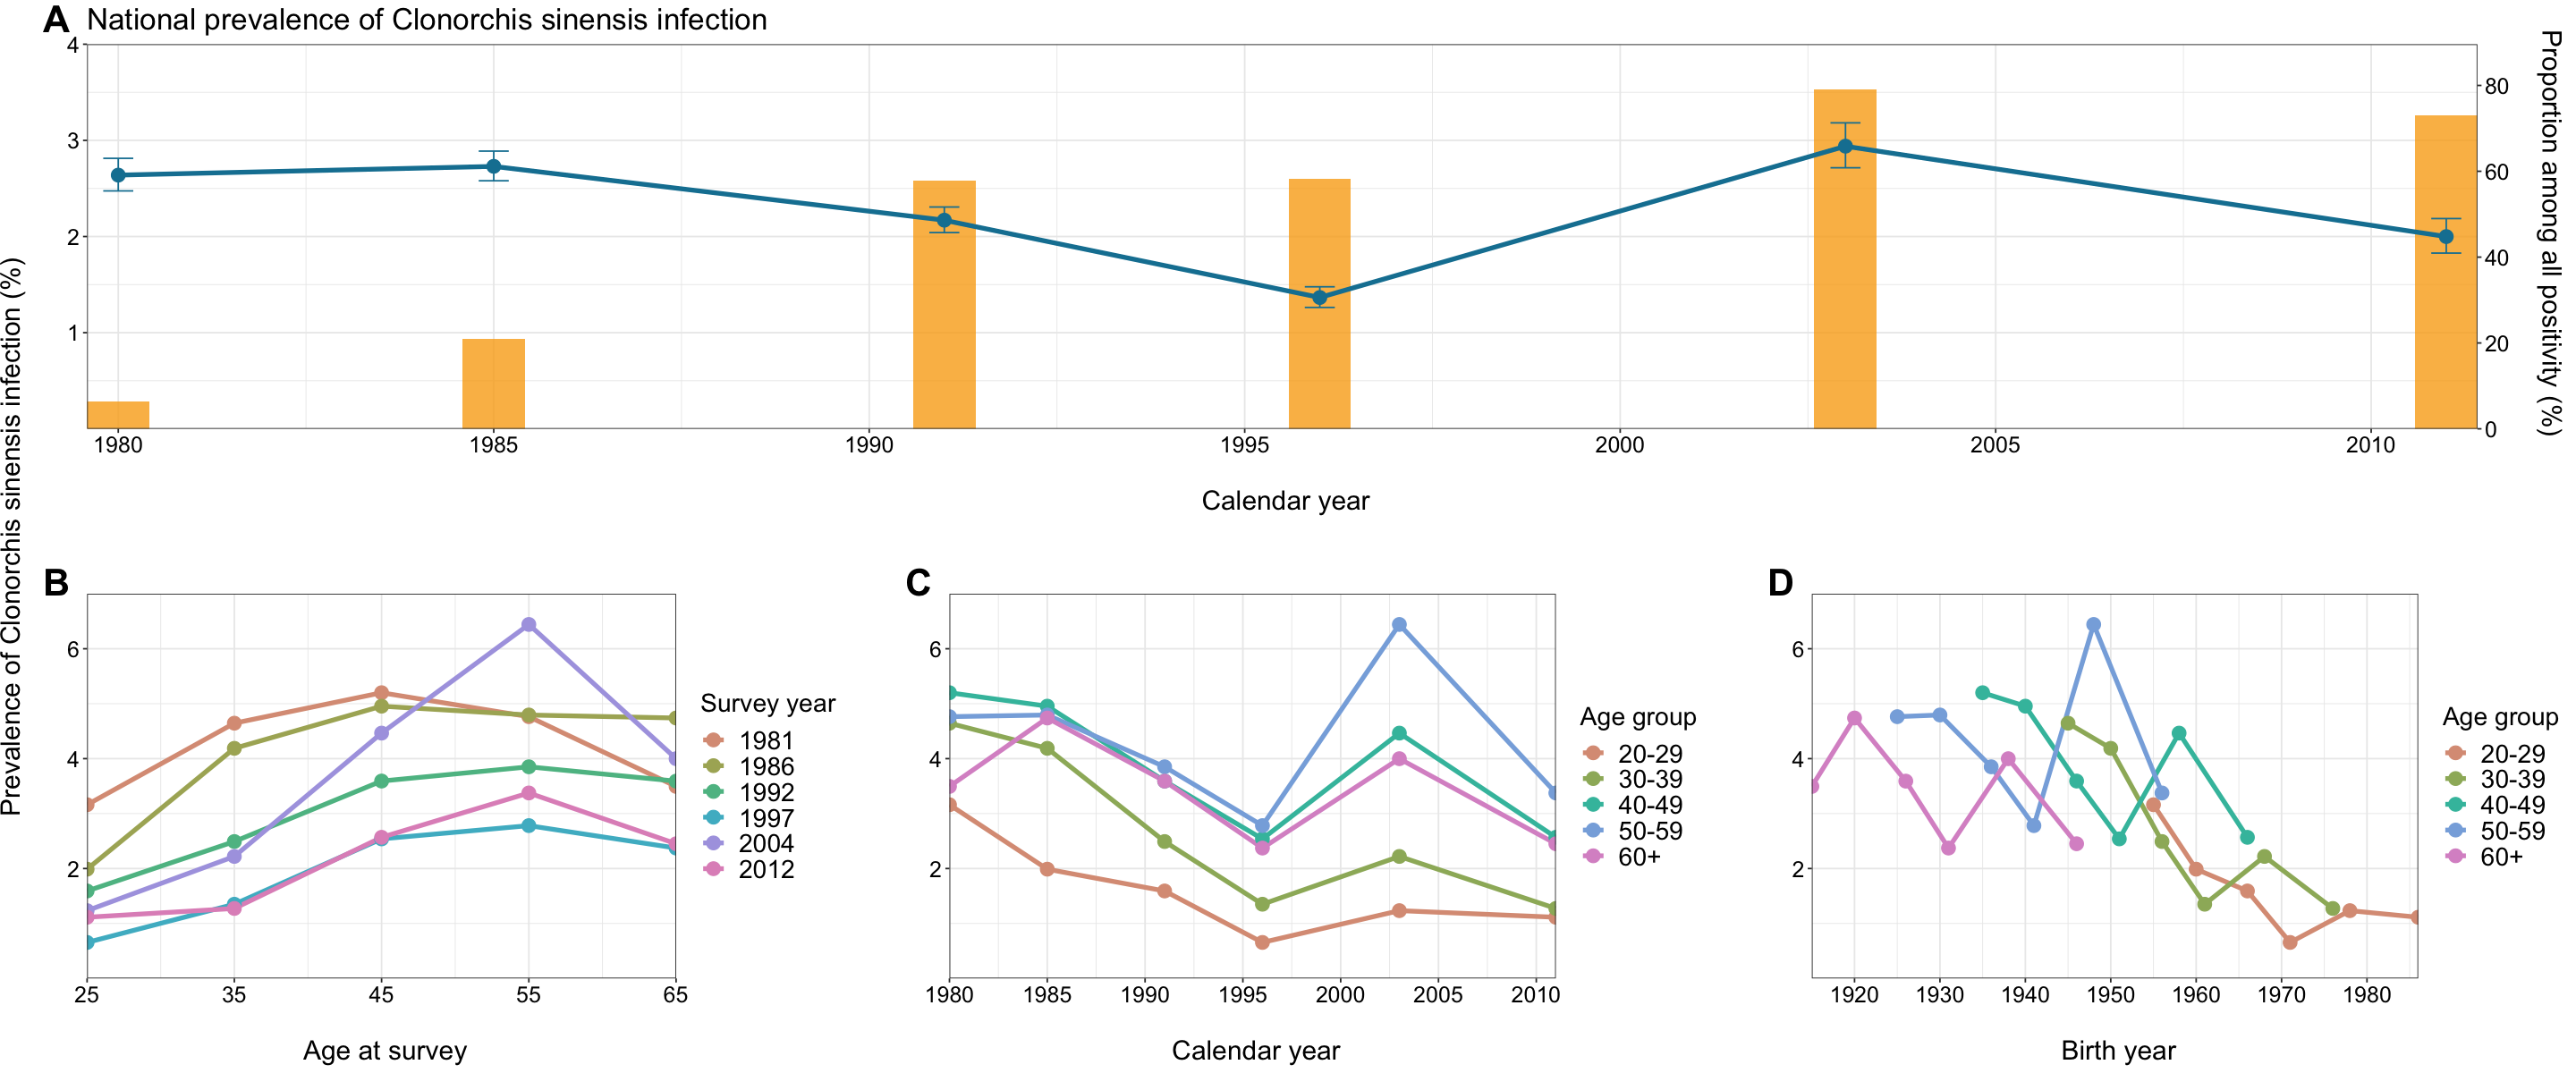

In [17]:
options(repr.plot.width=8,repr.plot.height=6)

prevalence <- c(.026, .027, .022, .014, .029, .019)
as.data.frame(prevalence) %>% 
mutate(year = c(1981, 1986, 1992, 1997, 2004, 2012)) %>%
mutate(all = c(.411, .129, .038, .024, .0367, .026)) %>%
mutate(prop = prevalence/all) %>%
mutate(Cs = c(924, 1190, 1018, 626, 604, 479), 
       total= c(35018, 43590, 46912, 45832, 20546, 23956)) %>% mutate(prevalence = Cs/total) %>%
rowwise() %>% mutate(lower=as.numeric(prop.test(Cs, total)[[6]][1]),
                     upper=as.numeric(prop.test(Cs, total)[[6]][2])) -> prev

scaling_parameter=max(prev$prevalence)/max(prev$prop)
adj=1.2

prev %>%
ggplot() + 
geom_bar(aes(x=year, y=prop*scaling_parameter*adj*100), fill="#FAAB18", stat='identity', width=0.83, alpha=0.8) +
geom_line(aes(x=year, y=prevalence*100), linewidth=1.5, color="#1380A1") +
geom_point(aes(x=year, y=prevalence*100), size=4, color="#1380A1") +
geom_errorbar(aes(x=year, ymin=lower*100, ymax=upper*100), colour="#1380A1", width=.4) +
labs(x="\n Calendar year", y="") + ggtitle("National prevalence of Clonorchis sinensis infection") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=20, color="black"),
      axis.title = element_text(size=18, color="black"),
      axis.text = element_text(size=15, color="black"), 
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 17)) +
scale_y_continuous(expand=c(0,0), limit=c(0, 4), breaks=c(1, 2, 3, 4, 5),
                   sec.axis = sec_axis(~./(scaling_parameter*adj), breaks=c(0, 20, 40, 60, 80), 
                                       name = "Proportion among all positivity (%) \n ")) +
scale_x_continuous(expand=c(0,0), breaks = seq(1971, 2012, by=5), labels=seq(1970, 2010, by=5)) -> fig_A

ggarrange(fig_A, ncol = 1, nrow = 1, labels = c("A"), font.label = list(size = 25), vjust=1.2) -> fig_A

options(repr.plot.width=24,repr.plot.height=10)
ggarrange(fig_A, ggplot() + theme_void(), fig_BCD, 
          ncol = 1, nrow = 3, heights = c(1, 0.05, 1), align = "hv") -> fig_total

annotate_figure(fig_total, left=text_grob("Prevalence of Clonorchis sinensis infection (%)", 
                                          size=18, rot=90, hjust=0.5, vjust=0.25))

# APC analysis

In [18]:
#### APC analysis only using individuals aged 19 and over
all_df_ageprev %>% rename(period=year) %>% filter(age >= 20 & period >= 1981) -> df_cut_APC

df_cut_APC %>% dplyr::select(period, age, prevalence) %>%
spread(key='period', value='prevalence') %>%
dplyr::select(-age) %>% as.matrix() -> bi_rate

rownames(bi_rate) <- sort(unique(df_cut_APC$age))

In [19]:
#### for the Age & Period effect
df_cut_APC %>% rename(R=prevalence, D=Cs, Y=total, A=age, P=period) %>%
dplyr::select(A, P, D, Y, R) %>% mutate(C=P-A) -> df_APC

combinations <- expand.grid(3:10, 3:10, 3:10)

options(warn=-1)
AIC_list1 <- list()
for (i in 1:nrow(combinations)){
    apc_result <- apc.fit(df_APC, npar=c(as.numeric(combinations[i,])), model="bs", 
                          dist="poisson", parm="APC", scale=10^2, 
                          ref.c=min(df_APC$C), ref.p=min(df_APC$P), print.AOV = FALSE)
    AIC_list1[[i]] <- as.numeric(apc_result[2]$Model[11])
}

do.call(rbind, AIC_list1) %>% as.data.frame() %>% mutate(npar=1:nrow(combinations)) %>% slice(which.min(V1))
options(warn=0)

V1,npar
<dbl>,<int>
267.1913,425


In [20]:
#### for the Age effect
df_cut_APC %>% rename(R=prevalence, D=Cs, Y=total, A=age, P=period) %>%
dplyr::select(A, P, D, Y, R) %>% mutate(C=P-A) -> df_APC

apc_result <- apc.fit(df_APC, npar=c(3, 8, 9), model="bs", dist="poisson", parm="APC", scale=10^2, 
                      ref.c=min(df_APC$C), ref.p=min(df_APC$P))

#### for the Cohort effect
apc_result2 <- apc.fit(df_APC, npar=c(3, 8, 9), model="bs", dist="poisson", parm="AC-P", scale=10^2, 
                      ref.c=min(df_APC$C), ref.p=min(df_APC$P))

#### for the Period effect
apc_result3 <- apc.fit(df_APC, npar=c(3, 8, 9), model="bs", dist="poisson", parm="AP-C", scale=10^2, 
                      ref.c=min(df_APC$C), ref.p=min(df_APC$P))

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”


[1] "ML of APC-model Poisson with log(Y) offset : ( APC ):\n"
              Model      AIC Mod. df. Mod. dev. Test df. Test dev.
1               Age 744.0001       26 536.16062       NA        NA
2         Age-drift 541.2410       25 331.40159        1 204.75903
3        Age-Cohort 488.3462       17 262.50674        8  68.89485
4 Age-Period-Cohort 269.1475       12  33.30809        5 229.19865
5        Age-Period 325.1064       20 105.26695        8  71.95886
6         Age-drift 541.2410       25 331.40159        5 226.13464
                                                 Pr(>Chi) Test dev/df
1                                                      NA          NA
2 0.00000000000000000000000000000000000000000000019114608  204.759025
3 0.00000000000815325713894209316899350921080866206290538    8.611856
4 0.00000000000000000000000000000000000000000000001588379   45.839730
5 0.00000000000200000279048195173034002260439923520434977    8.994857
6 0.000000000000000000000000000000000000000000000

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”


[1] "Sequential modelling Poisson with log(Y) offset : ( AC-P ):\n"
              Model      AIC Mod. df. Mod. dev. Test df. Test dev.
1               Age 744.0001       26 536.16062       NA        NA
2         Age-drift 541.2410       25 331.40159        1 204.75903
3        Age-Cohort 488.3462       17 262.50674        8  68.89485
4 Age-Period-Cohort 269.1475       12  33.30809        5 229.19865
5        Age-Period 325.1064       20 105.26695        8  71.95886
6         Age-drift 541.2410       25 331.40159        5 226.13464
                                                 Pr(>Chi) Test dev/df
1                                                      NA          NA
2 0.00000000000000000000000000000000000000000000019114608  204.759025
3 0.00000000000815325713894209316899350921080866206290538    8.611856
4 0.00000000000000000000000000000000000000000000001588379   45.839730
5 0.00000000000200000279048195173034002260439923520434977    8.994857
6 0.000000000000000000000000000000000000000

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: algorithm did not converge”


[1] "Sequential modelling Poisson with log(Y) offset : ( AP-C ):\n"
              Model      AIC Mod. df. Mod. dev. Test df. Test dev.
1               Age 744.0001       26 536.16062       NA        NA
2         Age-drift 541.2410       25 331.40159        1 204.75903
3        Age-Cohort 488.3462       17 262.50674        8  68.89485
4 Age-Period-Cohort 269.1475       12  33.30809        5 229.19865
5        Age-Period 325.1064       20 105.26695        8  71.95886
6         Age-drift 541.2410       25 331.40159        5 226.13464
                                                 Pr(>Chi) Test dev/df
1                                                      NA          NA
2 0.00000000000000000000000000000000000000000000019114608  204.759025
3 0.00000000000815325713894209316899350921080866206290538    8.611856
4 0.00000000000000000000000000000000000000000000001588379   45.839730
5 0.00000000000200000279048195173034002260439923520434977    8.994857
6 0.000000000000000000000000000000000000000

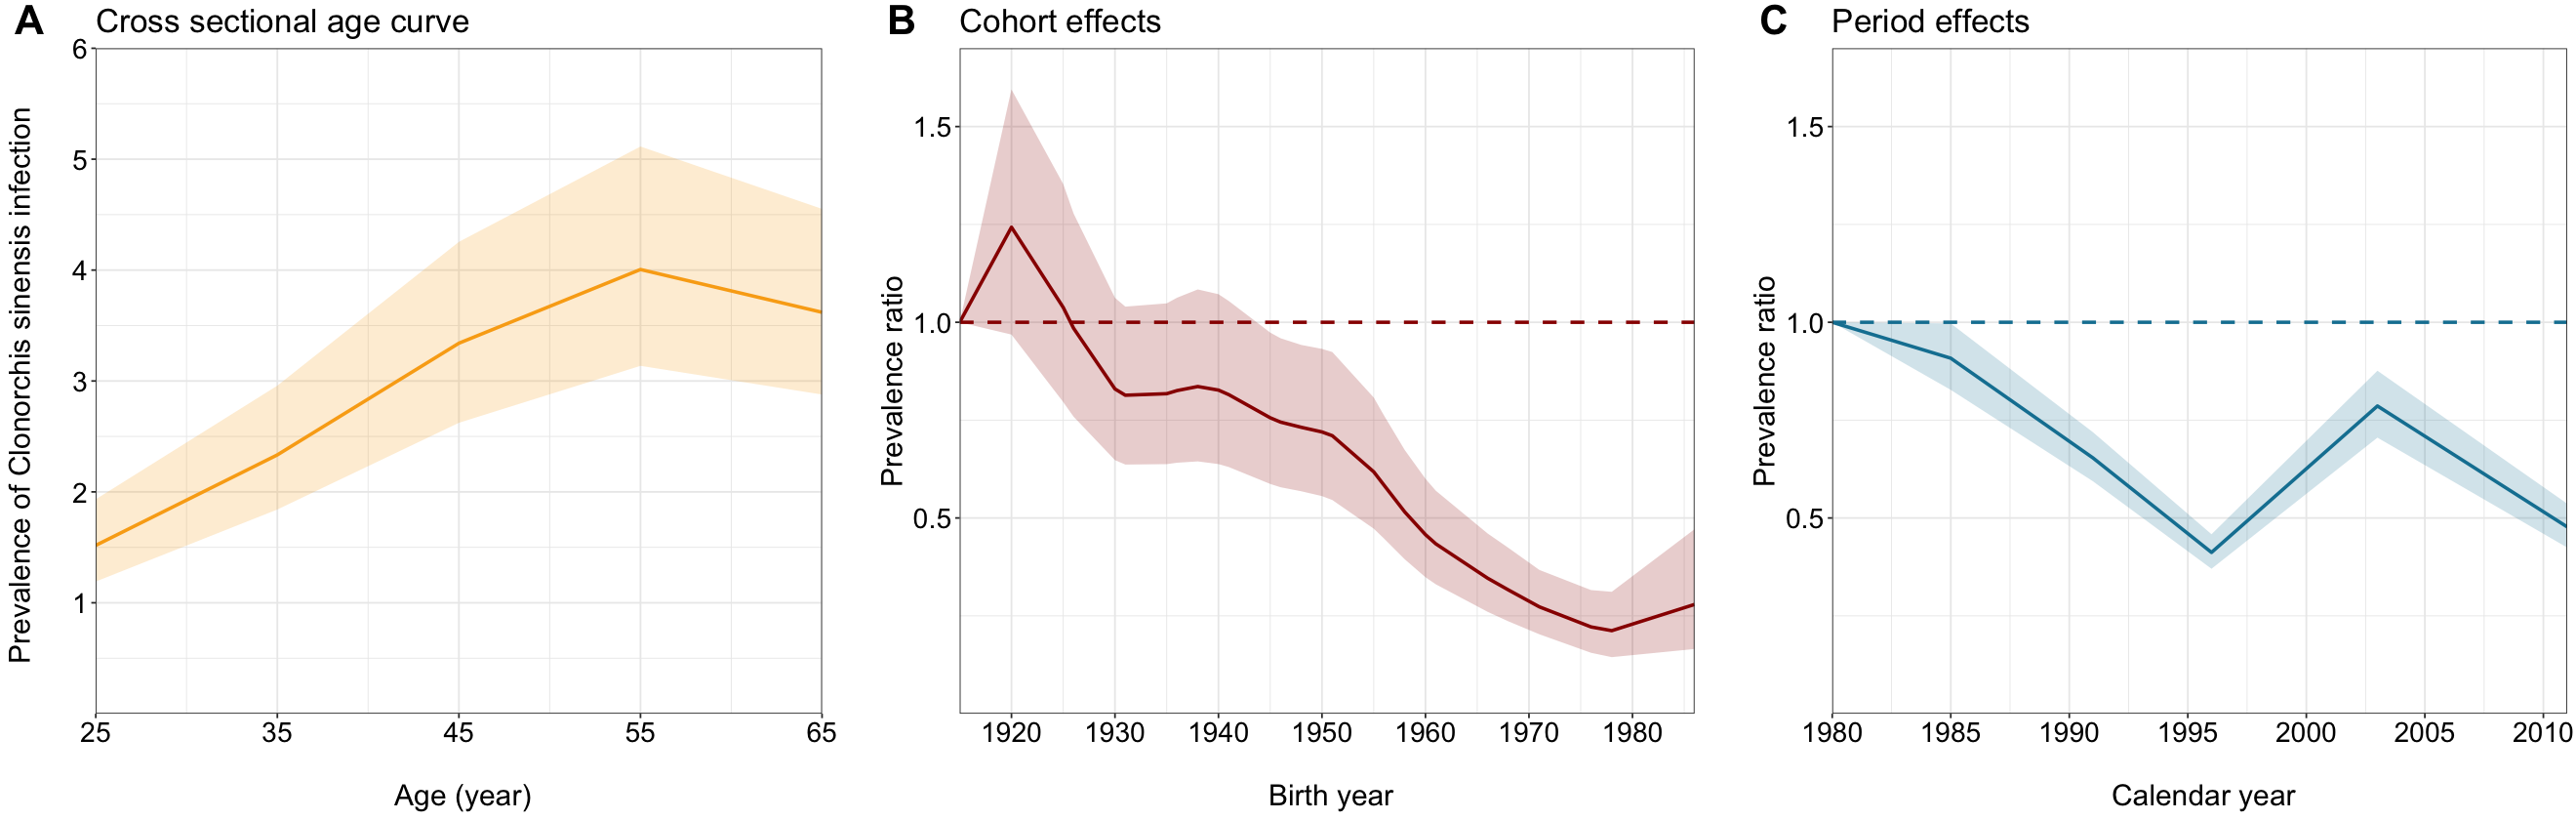

In [21]:
options(repr.plot.width=7,repr.plot.height=7)

apc_result$Age %>% as.data.frame() %>% rename(lower='2.5%', upper='97.5%') %>%
ggplot() + 
geom_line(aes(x = Age, y = Rate), linewidth=1, colour="#FAAB18") +
geom_ribbon(aes(x=Age, ymax=upper, ymin=lower), fill="#FAAB18", alpha = 0.2) +
ggtitle("Cross sectional age curve") +
labs(x="\n Age (year)", y="Prevalence of Clonorchis sinensis infection \n") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=20, color="black"),
      axis.title = element_text(size=18, color="black"),
      axis.text = element_text(size=17, color="black")) +
scale_x_continuous(expand=c(0,0), limit=c(25, 65)) +
scale_y_continuous(expand=c(0,0), limit=c(0, 6), breaks=c(1, 2, 3, 4, 5, 6)) -> age_figure

apc_result3$Per %>% as.data.frame() %>% rename(rr='P.eff', lower='2.5%', upper='97.5%') %>%
ggplot() + 
geom_line(aes(x = Per, y = rr), linewidth=1, colour="#1380A1") +
geom_ribbon(aes(x=Per, ymax=upper, ymin=lower), fill="#1380A1", alpha = 0.2) +
ggtitle("Period effects") +
labs(x="\n Calendar year", y="Prevalence ratio") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=20, color="black"),
      axis.title = element_text(size=18, color="black"),
      axis.text = element_text(size=17, color="black")) +
scale_x_continuous(expand=c(0,0), breaks = seq(1981, 2012, by=5), labels=seq(1980, 2010, by=5)) +
scale_y_continuous(expand=c(0,0), limit=c(0, 1.7), breaks=c(0.5, 1.0, 1.5, 2)) +
geom_hline(yintercept=1, linetype="dashed", color = "#1380A1", linewidth =1)-> per_figure

apc_result2$Coh %>% as.data.frame() %>% rename(rr='C.eff', lower='2.5%', upper='97.5%') %>%
ggplot() + 
geom_line(aes(x = Cph, y = rr), linewidth=1, colour="#990000") +
geom_ribbon(aes(x=Cph, ymax=upper, ymin=lower), fill="#990000", alpha = 0.2) +
ggtitle("Cohort effects") +
labs(x="\n Birth year", y="Prevalence ratio") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=20, color="black"),
      axis.title = element_text(size=18, color="black"),
      axis.text = element_text(size=17, color="black")) +

scale_x_continuous(expand=c(0,0), breaks = seq(1921,1992, by=10), labels=seq(1920,1990, by=10)) +
scale_y_continuous(expand=c(0,0), limit=c(0, 1.7), breaks=c(0.5, 1.0, 1.5, 2)) +
geom_hline(yintercept=1, linetype="dashed", color = "#990000", linewidth =1) -> coh_figure

options(repr.plot.width=22,repr.plot.height=7)
ggarrange(age_figure, ggplot() + theme_void(), coh_figure, ggplot() + theme_void(), per_figure,
          ncol = 5, nrow = 1, widths = c(1, 0.05, 1, 0.05, 1),  
          labels = c("A", "", "B", "", "C"), font.label = list(size = 25), vjust=1.15)

# Projection using a Bayesian APC approach

In [22]:
proj_year = 2023
year_list <- unique(df_APC$P)
adjyear_list <- seq(1981, proj_year, by=1)

In [23]:
cbind(as.data.frame(rep(adjyear_list, each=length(seq(25, 65, by=10)))),
      as.data.frame(rep(seq(25, 65, by=10), length(adjyear_list)))) -> temp
colnames(temp) <- c("P", "A")

merge(df_APC, temp, by=c("P", "A"), all.y=TRUE) %>% mutate(C=P-A) %>% arrange(P, A) -> df_APC_mod

In [24]:
read.csv("../../data/pop_proj.csv") -> df_proj_pop
as.data.frame(lapply(df_proj_pop, rep, 5)) %>% arrange(year) %>% mutate(year=1980:2034) %>%
filter(year >= 1981 & year <= proj_year) %>% rename(P=year) -> df_pop

df_pop %<>% gather(A, "Pop", -P) %>% 
mutate(A=case_when(A==c("X20")~c(25), A==c("X30")~c(35), A==c("X40")~c(45), A==c("X50")~c(55), A==c("X60")~c(65)))

merge(df_APC_mod, df_pop, by=c("P", "A")) %>% mutate(D=round(R*Pop)) %>% rename(Y_org=Y, Y=Pop) %>% 
dplyr::select(P, A, D, Y, R, C) -> df_APC_mod

In [25]:
df_APC_mod %>% dplyr::select(A, P, D) %>% spread(key='A', value='D') %>% dplyr::select(-P) -> df_nomi
colnames(df_nomi) <- c("20-29", "30-39", "40-49", "50-59", "60-65")

df_APC_mod %>% dplyr::select(A, P, Y) %>% spread(key='A', value='Y') %>% dplyr::select(-P) -> df_denomi
colnames(df_denomi) <- c("20-29", "30-39", "40-49", "50-59", "60-65")


rownames(df_nomi) <- adjyear_list
rownames(df_denomi) <- adjyear_list

In [26]:
df_cut_APC %>% rowwise() %>% 
mutate(lower=as.numeric(prop.test(Cs, total)[[6]][1])*100,
       upper=as.numeric(prop.test(Cs, total)[[6]][2])*100) %>% ungroup()-> df_data

In [27]:
df_APClist <- APCList(as.data.frame(df_nomi), as.data.frame(df_denomi), gf=1)           
result <- BAPC(df_APClist, predict=list(npredict=3, retro=TRUE), secondDiff=FALSE, verbose=FALSE)

res <- qapc(result, percentiles=c(0.05, 0.5, 0.95))
res2 <- qapc(result, percentiles=c(0.25, 0.5, 0.75))

Warning message in .recacheSubclasses(def@className, def, env):
“undefined subclass "ndiMatrix" of class "replValueSp"; definition not updated”


In [29]:
read.csv("prev_atrisk.csv") %>% filter(year >= 2015) -> df_at_risk
df_at_risk %<>% 
mutate(age=case_when(Age %in% c("20-24", "25-29") ~ c("20-29"),
                     Age %in% c("30-34", "35-39") ~ c("30-39"),
                     Age %in% c("40-44", "45-49") ~ c("40-49"),
                     Age %in% c("50-54", "55-59") ~ c("50-59"), TRUE ~ Age)) %>%
group_by(year, age) %>%  
mutate(agg_total=sum(total), agg_Cs=sum(Cs), prevalence=sum(Cs)/sum(total)*100) %>% ungroup() %>%
dplyr::select(age, agg_total, agg_Cs, prevalence, year) %>% distinct() %>% 
rename(Cs=agg_Cs, Age=age, total=agg_total) %>%
rowwise() %>% mutate(lower=as.numeric(prop.test(Cs, total)[[6]][1])*100,
                     upper=as.numeric(prop.test(Cs, total)[[6]][2])*100)

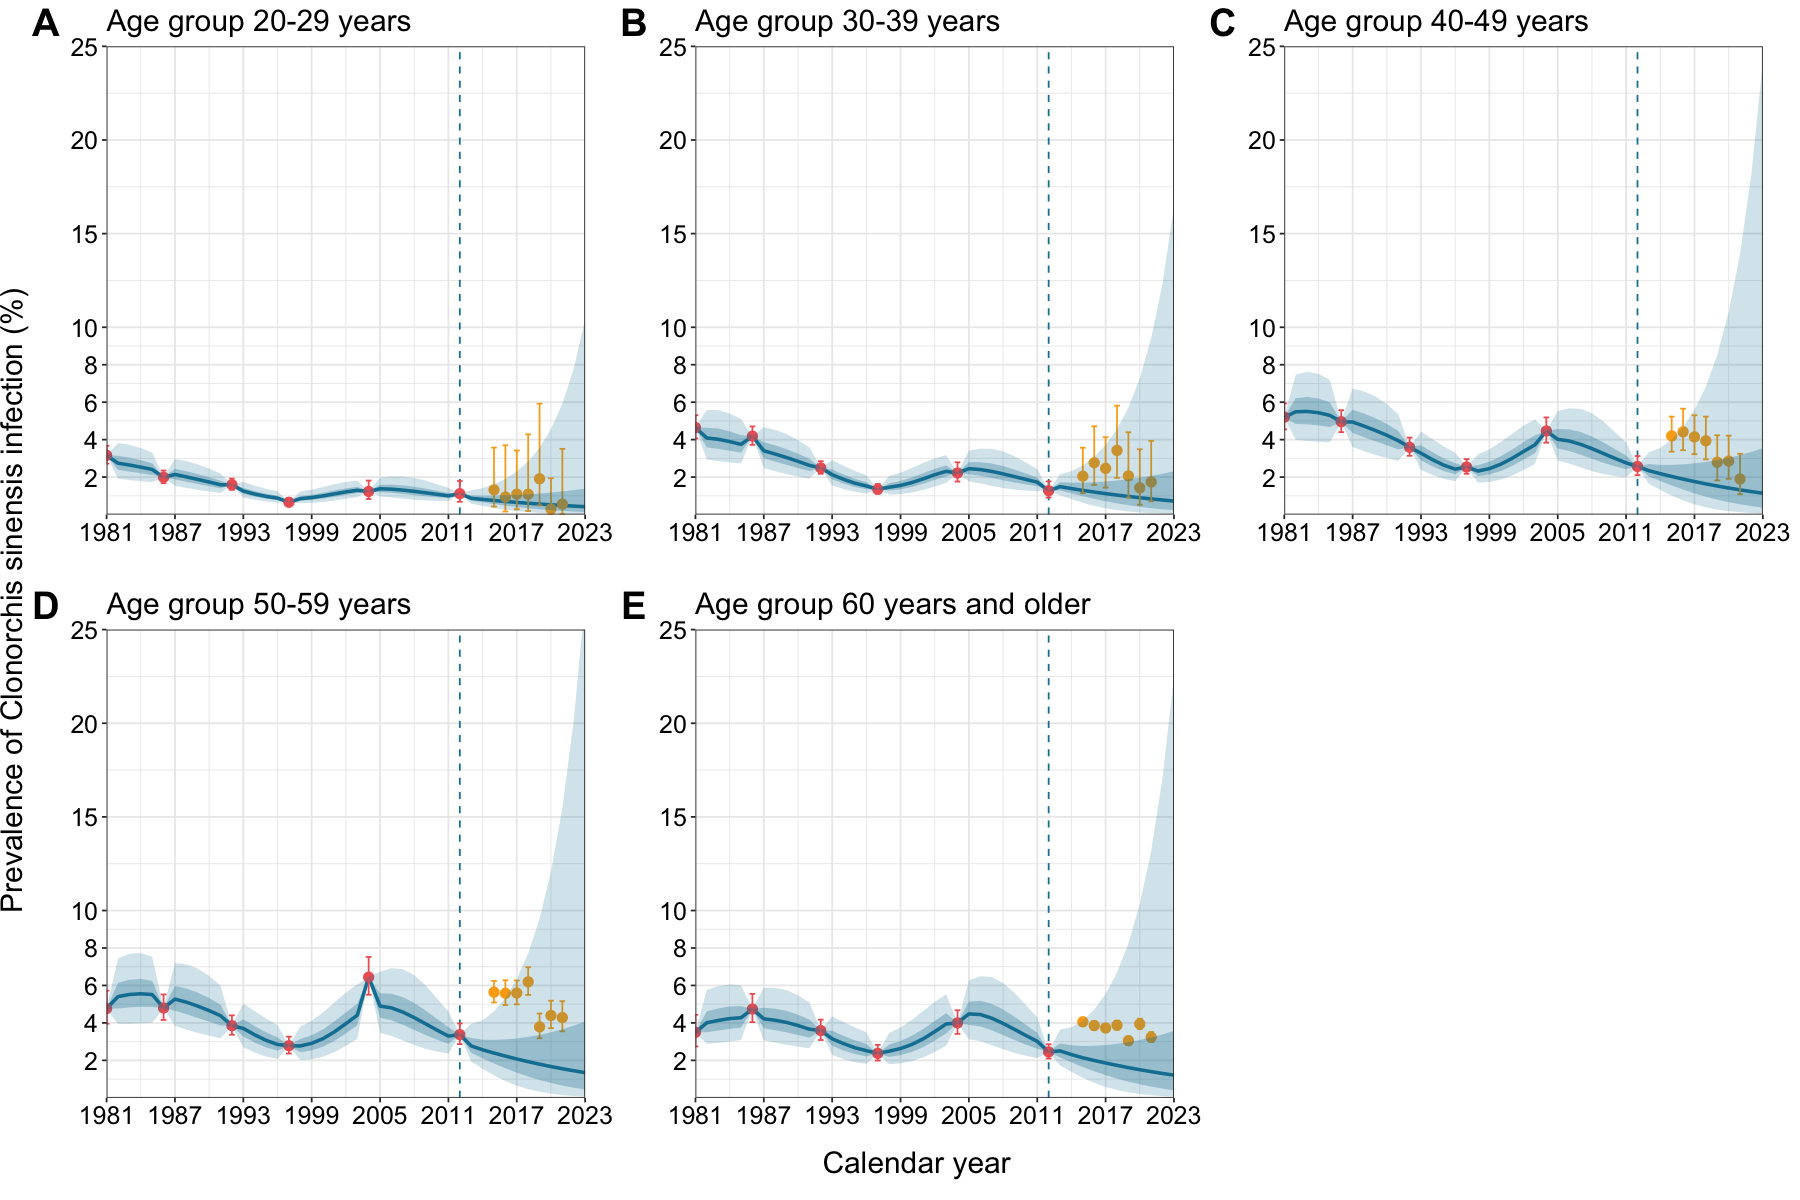

In [30]:
options(repr.plot.width=5,repr.plot.height=5, warn=-1)

limit_y=25; fig_year=2023; int_by=6; breaks_int=c(2, 4, 6, 8, 10, 15, 20, 25)

agespec.rate(res)[[1]] %>% as.data.frame() %>% rename(lower='0.05Q', median='0.5Q', upper='0.95Q') %>%
mutate(year=c(1981:proj_year)) %>%
ggplot() +
geom_line(aes(x=year, y=median*100),linewidth=1, color="#1380A1") +
geom_vline(xintercept=2012, linetype="dashed", color="#1380A1") +
geom_point(data=df_APC_mod %>% filter(A==unique(df_APC_mod$A)[1]), aes(x=P, y=R*100), color="indianred2", size=2.5) +
geom_errorbar(data=df_data %>% filter(age==25), aes(x=period, ymin=lower, ymax=upper), colour="indianred2", width=.5) +
geom_point(data=df_at_risk %>% filter(Age==c("20-29")), aes(x=year, y=prevalence), color="#FAAB18", size=2.5) +
geom_errorbar(data=df_at_risk %>% filter(Age==c("20-29")), aes(x=year, ymin=lower, ymax=upper), colour="#FAAB18", width=.5) +

geom_ribbon(aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.2) +
geom_ribbon(data=agespec.rate(res2)[[1]] %>% as.data.frame() %>% 
            rename(lower='0.25Q', median='0.5Q', upper='0.75Q') %>% mutate(year=c(1981:proj_year)),
            aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.3) +
ggtitle("Age group 20-29 years") + labs(x="", y="") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=18, color="black"),
      axis.title = element_text(size=15, color="black"),
      axis.text = element_text(size=15, color="black")) +
scale_x_continuous(expand=c(0,0), breaks = seq(1981,fig_year, by=int_by), labels=seq(1981,fig_year, by=int_by)) +
scale_y_continuous(expand=c(0,0), breaks=breaks_int) +
coord_cartesian(ylim=c(0, limit_y), xlim=c(1981, fig_year)) -> fig1

agespec.rate(res)[[2]] %>% as.data.frame() %>% rename(lower='0.05Q', median='0.5Q', upper='0.95Q') %>%
mutate(year=c(1981:proj_year)) %>%
ggplot() +
geom_line(aes(x=year, y=median*100),linewidth=1, color="#1380A1") +
geom_vline(xintercept=2012, linetype="dashed", color="#1380A1") +
geom_point(data=df_APC_mod %>% filter(A==unique(df_APC_mod$A)[2]), aes(x=P, y=R*100), color="indianred2", size=2.5) +
geom_errorbar(data=df_data %>% filter(age==35), aes(x=period, ymin=lower, ymax=upper), colour="indianred2", width=.5) +
geom_point(data=df_at_risk %>% filter(Age==c("30-39")), aes(x=year, y=prevalence), color="#FAAB18", size=2.5) +
geom_errorbar(data=df_at_risk %>% filter(Age==c("30-39")), aes(x=year, ymin=lower, ymax=upper), colour="#FAAB18", width=.5) +
geom_ribbon(aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.2) +
geom_ribbon(data=agespec.rate(res2)[[2]] %>% as.data.frame() %>% 
            rename(lower='0.25Q', median='0.5Q', upper='0.75Q') %>% mutate(year=c(1981:proj_year)),
            aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.3) +
ggtitle("Age group 30-39 years") + labs(x="", y="") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=18, color="black"),
      axis.title = element_text(size=15, color="black"),
      axis.text = element_text(size=15, color="black")) +
scale_x_continuous(expand=c(0,0), breaks = seq(1981,fig_year, by=int_by), labels=seq(1981,fig_year, by=int_by)) +
scale_y_continuous(expand=c(0,0), breaks=breaks_int) +
coord_cartesian(ylim=c(0, limit_y), xlim=c(1981, fig_year)) -> fig2

agespec.rate(res)[[3]] %>% as.data.frame() %>% rename(lower='0.05Q', median='0.5Q', upper='0.95Q') %>%
mutate(year=c(1981:proj_year)) %>%
ggplot() +
geom_line(aes(x=year, y=median*100),linewidth=1, color="#1380A1") +
geom_vline(xintercept=2012, linetype="dashed", color="#1380A1") +
geom_point(data=df_APC_mod %>% filter(A==unique(df_APC_mod$A)[3]), aes(x=P, y=R*100), color="indianred2", size=2.5) +
geom_errorbar(data=df_data %>% filter(age==45), aes(x=period, ymin=lower, ymax=upper), colour="indianred2", width=.5) +
geom_point(data=df_at_risk %>% filter(Age==c("40-49")), aes(x=year, y=prevalence), color="#FAAB18", size=2.5) +
geom_errorbar(data=df_at_risk %>% filter(Age==c("40-49")), aes(x=year, ymin=lower, ymax=upper), colour="#FAAB18", width=.5) +
geom_ribbon(aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.2) +
geom_ribbon(data=agespec.rate(res2)[[3]] %>% as.data.frame() %>% 
            rename(lower='0.25Q', median='0.5Q', upper='0.75Q') %>% mutate(year=c(1981:proj_year)),
            aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.3) +
ggtitle("Age group 40-49 years") + labs(x="", y="") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=18, color="black"),
      axis.title = element_text(size=15, color="black"),
      axis.text = element_text(size=15, color="black")) +
scale_x_continuous(expand=c(0,0), breaks = seq(1981,fig_year, by=int_by), labels=seq(1981,fig_year, by=int_by)) +
scale_y_continuous(expand=c(0,0), breaks=breaks_int) +
coord_cartesian(ylim=c(0, limit_y), xlim=c(1981, fig_year)) -> fig3

agespec.rate(res)[[4]] %>% as.data.frame() %>% rename(lower='0.05Q', median='0.5Q', upper='0.95Q') %>%
mutate(year=c(1981:proj_year)) %>%
ggplot() +
geom_line(aes(x=year, y=median*100),linewidth=1, color="#1380A1") +
geom_vline(xintercept=2012, linetype="dashed", color="#1380A1") +
geom_point(data=df_APC_mod %>% filter(A==unique(df_APC_mod$A)[4]), aes(x=P, y=R*100), color="indianred2", size=2.5) +
geom_errorbar(data=df_data %>% filter(age==55), aes(x=period, ymin=lower, ymax=upper), colour="indianred2", width=.5) +
geom_point(data=df_at_risk %>% filter(Age==c("50-59")), aes(x=year, y=prevalence), color="#FAAB18", size=2.5) +
geom_errorbar(data=df_at_risk %>% filter(Age==c("50-59")), aes(x=year, ymin=lower, ymax=upper), colour="#FAAB18", width=.5) +
geom_ribbon(aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.2) +
geom_ribbon(data=agespec.rate(res2)[[4]] %>% as.data.frame() %>% 
            rename(lower='0.25Q', median='0.5Q', upper='0.75Q') %>% mutate(year=c(1981:proj_year)),
            aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.3) +
ggtitle("Age group 50-59 years") + labs(x="", y="") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=18, color="black"),
      axis.title = element_text(size=15, color="black"),
      axis.text = element_text(size=15, color="black")) +
scale_x_continuous(expand=c(0,0), breaks = seq(1981,fig_year, by=int_by), labels=seq(1981,fig_year, by=int_by)) +
scale_y_continuous(expand=c(0,0), breaks=breaks_int) +
coord_cartesian(ylim=c(0, limit_y), xlim=c(1981, fig_year)) -> fig4

agespec.rate(res)[[5]] %>% as.data.frame() %>% rename(lower='0.05Q', median='0.5Q', upper='0.95Q') %>%
mutate(year=c(1981:proj_year)) %>%
ggplot() +
geom_line(aes(x=year, y=median*100),linewidth=1, color="#1380A1") +
geom_vline(xintercept=2012, linetype="dashed", color="#1380A1") +
geom_point(data=df_APC_mod %>% filter(A==unique(df_APC_mod$A)[5]), aes(x=P, y=R*100), color="indianred2", size=2.5) +
geom_errorbar(data=df_data %>% filter(age==65), aes(x=period, ymin=lower, ymax=upper), colour="indianred2", width=.5) +
geom_point(data=df_at_risk %>% filter(Age==c("60+")), aes(x=year, y=prevalence), color="#FAAB18", size=2.5) +
geom_errorbar(data=df_at_risk %>% filter(Age==c("60+")), aes(x=year, ymin=lower, ymax=upper), colour="#FAAB18", width=.5) +
geom_ribbon(aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.2) +
geom_ribbon(data=agespec.rate(res2)[[5]] %>% as.data.frame() %>% 
            rename(lower='0.25Q', median='0.5Q', upper='0.75Q') %>% mutate(year=c(1981:proj_year)),
            aes(x=year, ymax=upper*100, ymin=lower*100), fill="#1380A1", alpha = 0.3) +
ggtitle("Age group 60 years and older") + labs(x="", y="") +
theme(text = element_text(size=15, color="black"),
      plot.title = element_text(size=18, color="black"),
      axis.title = element_text(size=15, color="black"),
      axis.text = element_text(size=15, color="black")) +
scale_x_continuous(expand=c(0,0), breaks = seq(1981,fig_year, by=int_by), labels=seq(1981,fig_year, by=int_by)) +
scale_y_continuous(expand=c(0,0), breaks=breaks_int) +
coord_cartesian(ylim=c(0, limit_y), xlim=c(1981, fig_year)) -> fig5

options(repr.plot.width=15,repr.plot.height=10)
ggarrange(fig1, ggplot() + theme_void(), fig2, ggplot() + theme_void(), fig3, ggplot() + theme_void(),  
          fig4, ggplot() + theme_void(), fig5, ggplot() + theme_void(), ncol = 6, nrow = 2,
          widths = c(1, 0.05, 1, 0.05, 1, 0.05, 1, 0.05, 1, 0.05, 1),
          labels = c("A", "", "B", "", "C", "", "D", "", "E"), 
          font.label = list(size = 23), vjust=1.3, hjust=0.05) -> fig_total

annotate_figure(fig_total, 
                left=text_grob("Prevalence of Clonorchis sinensis infection (%)", size=18, rot=90, hjust=0.5, vjust=0.25),
                bottom=text_grob("Calendar year", size=18, vjust=-0.5))